<a href="https://colab.research.google.com/github/ps-research/Novel-Enhanced-Quantum-Representation-for-Biological-Sequence-Comparison/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit==0.40 pylatexenc qiskit-aer --quiet

In [ ]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================
import warnings
import os
import time
import gc
import pickle
from datetime import datetime
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm.notebook import tqdm

# Ensure Qiskit is installed
try:
    from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
    from qiskit_aer import AerSimulator
    from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
    from qiskit.visualization import circuit_drawer
except ImportError:
    print("Installing Qiskit...")
    !pip install qiskit==0.40 pylatexenc qiskit-aer --quiet
    from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
    from qiskit_aer import AerSimulator
    from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
    from qiskit.visualization import circuit_drawer
    print("Qiskit installed successfully.")

In [ ]:
# ----------------------------------------------------------------------------
# --- HOUSE STYLE CONFIGURATION ---
# ----------------------------------------------------------------------------


# 1. Define the official color palette (from viridis)
HOUSE_STYLE_COLORS = {
    'NEQR': '#440154',  # Dark Purple/Indigo
    'FRQI': '#fde725',  # Bright Yellow
    'Classical Hamming': '#21908d' # Teal
}
VIRIDIS_PALETTE = 'viridis'

# 2. Set consistent font sizes and plot aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
# Font Hierarchy
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# 3. Create a helper function to apply consistent styling to any plot
def apply_house_style(ax, title=""):
    """Applies consistent styling (grid, spines, title) to a Matplotlib axes object."""
    ax.grid(True, which='major', axis='y', linestyle='--', color='lightgray', zorder=0)
    sns.despine(ax=ax, top=True, right=True)
    ax.set_title(title, pad=15)
# ----------------------------------------------------------------------------

# Setup directories
os.makedirs('results', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)
os.makedirs('results/tables', exist_ok=True)
os.makedirs('results/checkpoints', exist_ok=True)

print("Quantum DNA Sequence Comparison Analysis (Enhanced with GC Content Analysis)")
print("=" * 70)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: 'results/'")

Quantum DNA Sequence Comparison Analysis (Enhanced with GC Content Analysis)
Started at: 2025-08-14 20:24:24
Output directory: 'results/'


In [ ]:
# ============================================================================
# SECTION 2: CORE QUANTUM CIRCUIT IMPLEMENTATIONS (Unchanged)
# ============================================================================

class QuantumDNAEncoder:
    """Base class for quantum DNA encoding methods."""
    @staticmethod
    def nucleotide_to_binary(nucleotide):
        mapping = {'A': '00', 'T': '01', 'G': '10', 'C': '11'}
        return mapping.get(nucleotide.upper(), '00')

    @staticmethod
    def nucleotide_to_angle(nucleotide):
        mapping = {'A': np.pi, 'C': np.pi / 2, 'T': np.pi / 6, 'G': 0}
        return mapping.get(nucleotide.upper(), 0)

class NEQREncoder(QuantumDNAEncoder):
    """NEQR implementation."""
    def create_swap_test_circuit(self, seq1, seq2):
        L = len(seq1)
        n_pos = int(np.ceil(np.log2(L))) if L > 1 else 1
        n_val = 2
        def create_encoding_gate(sequence):
            pos_reg_inner = QuantumRegister(n_pos)
            val_reg_inner = QuantumRegister(n_val)
            qc_enc = QuantumCircuit(pos_reg_inner, val_reg_inner, name=f'NEQR_Enc')
            qc_enc.h(pos_reg_inner)
            for i, nucleotide in enumerate(sequence):
                pos_bin = format(i, f'0{n_pos}b')
                nuc_bin = self.nucleotide_to_binary(nucleotide)
                for j, bit in enumerate(pos_bin):
                    if bit == '0': qc_enc.x(pos_reg_inner[j])
                for j, bit in enumerate(nuc_bin):
                    if bit == '1': qc_enc.mcx(pos_reg_inner[:], val_reg_inner[j])
                for j, bit in enumerate(pos_bin):
                    if bit == '0': qc_enc.x(pos_reg_inner[j])
            return qc_enc.to_gate()
        n_qubits_per_seq = n_pos + n_val
        ancilla = QuantumRegister(1, 'ancilla')
        reg1 = QuantumRegister(n_qubits_per_seq, 'seq1')
        reg2 = QuantumRegister(n_qubits_per_seq, 'seq2')
        creg = ClassicalRegister(1, 'c')
        qc = QuantumCircuit(ancilla, reg1, reg2, creg)
        qc.h(ancilla[0])
        qc.append(create_encoding_gate(seq1), reg1[:])
        qc.append(create_encoding_gate(seq2), reg2[:])
        for i in range(n_qubits_per_seq):
            qc.cswap(ancilla[0], reg1[i], reg2[i])
        qc.h(ancilla[0])
        qc.measure(ancilla[0], creg[0])
        return qc

class FRQIEncoder(QuantumDNAEncoder):
    """FRQI implementation."""
    def create_comparison_circuit(self, seq1, seq2):
        L = len(seq1)
        n_idx = int(np.ceil(np.log2(L))) if L > 1 else 1
        strip = QuantumRegister(1, 'strip')
        idx = QuantumRegister(n_idx, 'idx')
        dna = QuantumRegister(1, 'dna')
        creg = ClassicalRegister(1, 'c')
        qc = QuantumCircuit(strip, idx, dna, creg)
        qc.h(strip[0])
        qc.h(idx)
        for i in range(L):
            pos_bin = format(i, f'0{n_idx}b')
            for j, bit in enumerate(pos_bin):
                if bit == '0': qc.x(idx[j])
            angle1 = self.nucleotide_to_angle(seq1[i])
            angle2 = self.nucleotide_to_angle(seq2[i])
            controls = [strip[0]] + list(idx[:])
            qc.x(strip[0])
            if angle1 != 0: qc.mcry(angle1, controls, dna[0])
            qc.x(strip[0])
            if angle2 != 0: qc.mcry(angle2, controls, dna[0])
            for j, bit in enumerate(pos_bin):
                if bit == '0': qc.x(idx[j])
        qc.h(strip[0])
        qc.measure(strip[0], creg[0])
        return qc

In [ ]:
# ============================================================================
# SECTION 3: UTILITY FUNCTIONS
# ============================================================================

class SequenceAnalyzer:
    """Utility class for sequence analysis."""
    @staticmethod
    def calculate_hamming_similarity(seq1, seq2):
        if len(seq1) != len(seq2): raise ValueError("Sequences must have equal length")
        return sum(c1 == c2 for c1, c2 in zip(seq1, seq2)) / len(seq1)

    @staticmethod
    def generate_random_sequence(length, gc_content=None):
        if gc_content is None:
            return ''.join(np.random.choice(['A', 'T', 'G', 'C'], length))
        if not (0 <= gc_content <= 1):
            raise ValueError("gc_content must be between 0 and 1.")
        gc_count = int(length * gc_content)
        at_count = length - gc_count
        sequence = ['G'] * (gc_count // 2) + ['C'] * (gc_count - gc_count // 2)
        sequence.extend(['A'] * (at_count // 2) + ['T'] * (at_count - at_count // 2))
        np.random.shuffle(sequence)
        return ''.join(sequence)

class SimulationRunner:
    """Class for running quantum simulations."""
    def __init__(self, shots=8192):
        self.shots = shots
        self.backend = AerSimulator()

    def run_circuit(self, circuit, noise_model=None):
        backend_to_run = AerSimulator(noise_model=noise_model) if noise_model else self.backend
        transpiled = transpile(circuit, backend_to_run)
        result = backend_to_run.run(transpiled, shots=self.shots).result()
        return result.get_counts()

    def calculate_similarity_from_counts(self, counts):
        p0 = counts.get('0', 0) / self.shots
        return p0 - (1 - p0)

    def run_neqr_simulation(self, seq1, seq2, noise_model=None):
        circuit = NEQREncoder().create_swap_test_circuit(seq1, seq2)
        counts = self.run_circuit(circuit, noise_model)
        return self.calculate_similarity_from_counts(counts)

    def run_frqi_simulation(self, seq1, seq2, noise_model=None):
        circuit = FRQIEncoder().create_comparison_circuit(seq1, seq2)
        counts = self.run_circuit(circuit, noise_model)
        return self.calculate_similarity_from_counts(counts)

In [ ]:
# ============================================================================
# SECTION 4: DIVERSITY ANALYSIS MODULE
# ============================================================================

class DiversityAnalysis:
    """Module for testing diverse sequence cases, including GC content extremes."""
    def __init__(self, runner):
        self.runner = runner
        self.results = None

    def generate_test_cases(self, length=6):
        return {
            'Identical Mix': [('ATCGAT', 'ATCGAT', 'Identical Mix')],
            'Max Difference': [('AAAAAA', 'GGGGGG', 'Max Diff')],
            'Single Mismatch': [('ATCGAT', 'ATCGTT', '1 Mismatch')],
            '0% vs 0% GC': [(SequenceAnalyzer.generate_random_sequence(length, 0.0), SequenceAnalyzer.generate_random_sequence(length, 0.0), '0% vs 0% GC')],
            '100% vs 100% GC': [(SequenceAnalyzer.generate_random_sequence(length, 1.0), SequenceAnalyzer.generate_random_sequence(length, 1.0), '100% vs 100% GC')],
            '0% vs 100% GC': [(SequenceAnalyzer.generate_random_sequence(length, 0.0), SequenceAnalyzer.generate_random_sequence(length, 1.0), '0% vs 100% GC')]
        }

    def analyze(self, n_trials=20):
        print("\n Running Enhanced Diversity Analysis...")
        test_cases = self.generate_test_cases()
        results_data = []
        for category, cases in test_cases.items():
            for seq1, seq2, desc in tqdm(cases, desc=f"Testing {category}"):
                hamming = SequenceAnalyzer.calculate_hamming_similarity(seq1, seq2)
                neqr_scores = [self.runner.run_neqr_simulation(seq1, seq2) for _ in range(n_trials)]
                frqi_scores = [self.runner.run_frqi_simulation(seq1, seq2) for _ in range(n_trials)]
                results_data.append({
                    'Description': desc, 'Hamming': hamming,
                    'NEQR_Mean': np.mean(neqr_scores), 'NEQR_Std': np.std(neqr_scores),
                    'FRQI_Mean': np.mean(frqi_scores), 'FRQI_Std': np.std(frqi_scores),
                })
        self.results = pd.DataFrame(results_data)
        return self.results

    def plot_results(self):
        """REFACTORED: Creates a proper grouped bar chart."""
        if self.results is None: raise ValueError("Run analysis first")

        fig, ax = plt.subplots(figsize=(14, 8))
        x = np.arange(len(self.results))
        width = 0.25

        # Plot bars for each method
        ax.bar(x - width, self.results['NEQR_Mean'], width, yerr=self.results['NEQR_Std'],
               label='NEQR', color=HOUSE_STYLE_COLORS['NEQR'], capsize=5, zorder=3)
        ax.bar(x, self.results['FRQI_Mean'], width, yerr=self.results['FRQI_Std'],
               label='FRQI', color=HOUSE_STYLE_COLORS['FRQI'], capsize=5, zorder=3)
        ax.bar(x + width, self.results['Hamming'], width,
               label='Classical Hamming', color=HOUSE_STYLE_COLORS['Classical Hamming'], zorder=3)

        ax.set_ylabel('Similarity Score')
        ax.set_xticks(x)
        ax.set_xticklabels(self.results['Description'], rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(bottom=0)

        # Apply the consistent house style
        apply_house_style(ax, title='Quantum vs. Classical Similarity for Diverse Cases')

        plt.tight_layout()
        plt.savefig('results/figures/diversity_comparison_grouped_bar.pdf')
        plt.show()

        self.results.to_csv('results/tables/diversity_results.csv', index=False)
        print(" Diversity analysis complete.")


In [ ]:
# ============================================================================
# SECTION 5: STATISTICAL ANALYSIS MODULE
# ============================================================================

class StatisticalAnalysis:
    """Module for statistical testing across different GC contents."""
    def __init__(self, runner):
        self.runner = runner
        self.results = None

    def analyze(self, n_sequences=15, sequence_length=6, gc_levels=[0.2, 0.5, 0.8]):
        print("\n Running Statistical Analysis across GC content...")
        results_data = []
        for gc in tqdm(gc_levels, desc="Testing GC content levels"):
            for _ in range(n_sequences):
                seq1 = SequenceAnalyzer.generate_random_sequence(sequence_length, gc_content=gc)
                seq2 = SequenceAnalyzer.generate_random_sequence(sequence_length, gc_content=gc)
                hamming = SequenceAnalyzer.calculate_hamming_similarity(seq1, seq2)
                neqr_sim = self.runner.run_neqr_simulation(seq1, seq2)
                frqi_sim = self.runner.run_frqi_simulation(seq1, seq2)
                results_data.append({
                    'gc_content': gc, 'hamming': hamming,
                    'neqr_sim': neqr_sim, 'frqi_sim': frqi_sim,
                    'neqr_error': abs(neqr_sim - hamming),
                    'frqi_error': abs(frqi_sim - hamming)
                })
        self.results = pd.DataFrame(results_data)
        return self.results

    def plot_correlation(self):
        """REFACTORED: Plot 1 - Correlation scatter plot."""
        if self.results is None: raise ValueError("Run analysis first")

        fig, ax = plt.subplots(figsize=(8, 8))

        # Melt data for cleaner plotting with Seaborn
        df_melt = self.results.melt(
            id_vars=['hamming', 'gc_content'],
            value_vars=['neqr_sim', 'frqi_sim'],
            var_name='Method',
            value_name='Quantum Similarity'
        )
        df_melt['Method'] = df_melt['Method'].str.replace('_sim', '').str.upper()

        sns.scatterplot(data=df_melt, x='hamming', y='Quantum Similarity',
                        hue='gc_content', style='Method', palette=VIRIDIS_PALETTE,
                        ax=ax, s=100, alpha=0.8)

        ax.plot([0, 1], [0, 1], 'r--', label='Perfect Agreement', zorder=1)
        ax.set_xlabel('Classical Hamming Similarity')
        ax.set_ylabel('Quantum Similarity')
        ax.set_aspect('equal', 'box')
        ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        apply_house_style(ax, title='Correlation of Quantum vs. Classical Similarity')

        plt.tight_layout()
        plt.savefig('results/figures/statistical_correlation.pdf', bbox_inches='tight')
        plt.show()

    def plot_error_distribution(self):
        """REFACTORED: Plot 2 - Error distribution box plot."""
        if self.results is None: raise ValueError("Run analysis first")

        fig, ax = plt.subplots(figsize=(10, 7))

        df_melt = self.results.melt(id_vars=['gc_content'], value_vars=['neqr_error', 'frqi_error'],
                                    var_name='Method', value_name='Absolute Error')
        df_melt['Method'] = df_melt['Method'].str.replace('_error', '').str.upper()

        sns.boxplot(data=df_melt, x='gc_content', y='Absolute Error', hue='Method',
                    ax=ax, palette=HOUSE_STYLE_COLORS)

        ax.set_xlabel('GC Content Level')
        ax.set_ylabel('Absolute Error')

        apply_house_style(ax, title='Absolute Error Distribution by GC Content')

        plt.tight_layout()
        plt.savefig('results/figures/statistical_error_boxplot.pdf')
        plt.show()

In [ ]:
# ============================================================================
# SECTION 6: NOISE ANALYSIS MODULE
# ============================================================================

class NoiseAnalysis:
    """Module for noise resilience testing across different GC contents."""
    def __init__(self, runner):
        self.runner = runner
        self.results = None

    def create_noise_model(self, rate):
        noise = NoiseModel()
        error_1q = depolarizing_error(rate, 1)
        error_2q = depolarizing_error(rate * 10, 2)
        noise.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'ry'])
        noise.add_all_qubit_quantum_error(error_2q, ['cx', 'swap', 'mcx', 'mcry'])
        return noise

    def analyze(self, noise_levels=[0, 0.001, 0.005], n_sequences=5, sequence_length=4, gc_levels=[0.2, 0.5, 0.8]):
        print("\n Running Noise Analysis across GC content...")
        results_data = []
        pbar = tqdm(total=len(noise_levels) * len(gc_levels) * n_sequences, desc="Noise Analysis")
        for noise_rate in noise_levels:
            noise_model = self.create_noise_model(noise_rate) if noise_rate > 0 else None
            for gc in gc_levels:
                for _ in range(n_sequences):
                    seq1 = SequenceAnalyzer.generate_random_sequence(sequence_length, gc)
                    seq2 = SequenceAnalyzer.generate_random_sequence(sequence_length, gc)
                    hamming = SequenceAnalyzer.calculate_hamming_similarity(seq1, seq2)
                    neqr_sim = self.runner.run_neqr_simulation(seq1, seq2, noise_model)
                    frqi_sim = self.runner.run_frqi_simulation(seq1, seq2, noise_model)
                    results_data.append({'noise': noise_rate, 'gc_content': gc, 'method': 'NEQR', 'error': abs(neqr_sim - hamming)})
                    results_data.append({'noise': noise_rate, 'gc_content': gc, 'method': 'FRQI', 'error': abs(frqi_sim - hamming)})
                    pbar.update(1)
        pbar.close()
        self.results = pd.DataFrame(results_data)
        return self.results

    def _plot_single_method_noise(self, method_name, ax):
        """Internal helper to plot noise for one method."""
        df_method = self.results[self.results['method'] == method_name]

        sns.lineplot(data=df_method, x='noise', y='error', hue='gc_content',
                     palette=VIRIDIS_PALETTE, marker='o', ax=ax, errorbar='sd', zorder=3)

        ax.set_xlabel("Depolarizing Error Rate")
        ax.set_ylabel("Mean Absolute Error")
        ax.set_xscale('symlog', linthresh=1e-4)
        ax.set_yscale('log')
        ax.legend(title='GC Content')

        apply_house_style(ax, title=f"Noise Resilience: {method_name}")

    def plot_noise_resilience(self):
        """REFACTORED: Creates separate plots for NEQR and FRQI noise resilience."""
        if self.results is None: raise ValueError("Run analysis first")

        # Plot for NEQR
        fig1, ax1 = plt.subplots(figsize=(8, 6))
        self._plot_single_method_noise('NEQR', ax1)
        plt.tight_layout()
        plt.savefig('results/figures/noise_resilience_neqr.pdf')
        plt.show()

        # Plot for FRQI
        fig2, ax2 = plt.subplots(figsize=(8, 6))
        self._plot_single_method_noise('FRQI', ax2)
        plt.tight_layout()
        plt.savefig('results/figures/noise_resilience_frqi.pdf')
        plt.show()

        self.results.to_csv('results/tables/noise_results_gc.csv', index=False)
        print(" Noise analysis complete.")


In [ ]:
# ============================================================================
# SECTION 7: REPORT PREPRATION MODULE
# ============================================================================

class ComprehensiveReport:
    """Module for generating a final summary report."""
    def generate_summary_table(self, stat_df, noise_df):
        summary = {}
        summary['Avg Error (All GC)'] = {
            'NEQR': stat_df['neqr_error'].mean(),
            'FRQI': stat_df['frqi_error'].mean()
        }
        neqr_worst_gc = stat_df.groupby('gc_content')['neqr_error'].mean().max()
        frqi_worst_gc = stat_df.groupby('gc_content')['frqi_error'].mean().max()
        summary['Worst-Case Error (by GC)'] = {'NEQR': neqr_worst_gc, 'FRQI': frqi_worst_gc}
        noise_level = noise_df['noise'].max()
        noise_at_max = noise_df[noise_df['noise'] == noise_level]
        summary[f'Error @ {noise_level:.3f} Noise'] = {
            'NEQR': noise_at_max[noise_at_max['method'] == 'NEQR']['error'].mean(),
            'FRQI': noise_at_max[noise_at_max['method'] == 'FRQI']['error'].mean()
        }
        summary_df = pd.DataFrame.from_dict(summary, orient='index')
        summary_df['NEQR_is_Better'] = summary_df['NEQR'] < summary_df['FRQI']
        return summary_df

    def create_final_report(self, all_results):
        """REFACTORED: Applies house style to the summary bar chart."""
        print("\n Generating Comprehensive Report...")
        summary_table = self.generate_summary_table(all_results['statistical'], all_results['noise'])

        fig, ax = plt.subplots(figsize=(10, 6))
        summary_table[['NEQR', 'FRQI']].plot(
            kind='bar',
            ax=ax,
            rot=0,
            color=[HOUSE_STYLE_COLORS['NEQR'], HOUSE_STYLE_COLORS['FRQI']],
            zorder=3
        )
        ax.set_ylabel('Error Value (Lower is Better)')
        ax.set_xlabel('')

        apply_house_style(ax, title='Overall Performance Comparison')

        plt.tight_layout()
        plt.savefig('results/figures/overall_comparison_summary.pdf')
        plt.show()

        summary_table.to_csv('results/tables/summary_table.csv')
        print(" Comprehensive report generated!")
        print("\n Summary of Results:")
        print(summary_table.round(4).to_string())
        return summary_table

In [ ]:
# ============================================================================
# SECTION 8: MAIN EXECUTION (Updated to call refactored plot functions)
# ============================================================================

def main():
    """Main execution function to run all enhanced analyses."""
    print("\n Starting Comprehensive Quantum DNA Sequence Analysis")
    all_results = {}
    runner = SimulationRunner(shots=8192)

    GC_LEVELS = [0.2, 0.5, 0.8]

    # 1. Diversity Analysis
    try:
        diversity_analyzer = DiversityAnalysis(runner)
        all_results['diversity'] = diversity_analyzer.analyze(n_trials=10)
        diversity_analyzer.plot_results() # This now creates the improved plot
        with open('results/checkpoints/checkpoint_diversity.pkl', 'wb') as f: pickle.dump(all_results['diversity'], f)
        gc.collect()
    except Exception as e: print(f"Diversity Analysis failed: {e}")

    # 2. Statistical Analysis with GC Content
    try:
        stat_analyzer = StatisticalAnalysis(runner)
        all_results['statistical'] = stat_analyzer.analyze(n_sequences=10, sequence_length=6, gc_levels=GC_LEVELS)
        stat_analyzer.plot_correlation()        # CALL SEPARATE PLOT 1
        stat_analyzer.plot_error_distribution() # CALL SEPARATE PLOT 2
        with open('results/checkpoints/checkpoint_statistical.pkl', 'wb') as f: pickle.dump(all_results['statistical'], f)
        gc.collect()
    except Exception as e: print(f"Statistical Analysis failed: {e}")

    # 3. Noise Analysis with GC Content
    try:
        noise_analyzer = NoiseAnalysis(runner)
        all_results['noise'] = noise_analyzer.analyze(noise_levels=[0, 0.0009, 0.002], n_sequences=5, sequence_length=4, gc_levels=GC_LEVELS)
        noise_analyzer.plot_noise_resilience()
        with open('results/checkpoints/checkpoint_noise.pkl', 'wb') as f: pickle.dump(all_results['noise'], f)
        gc.collect()
    except Exception as e: print(f"Noise Analysis failed: {e}")

    # 4. Generate Comprehensive Report
    try:
        if all(k in all_results for k in ['statistical', 'noise']):
            report_generator = ComprehensiveReport()
            report_generator.create_final_report(all_results)
        else:
            print("\nSkipping final report due to failures in previous steps.")
    except Exception as e: print(f"Report Generation failed: {e}")

    with open('results/all_results.pkl', 'wb') as f: pickle.dump(all_results, f)
    print("\n" + "="*70 + "\n ENHANCED ANALYSIS COMPLETE!\n" + "="*70)
    print(f"Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


 Starting Comprehensive Quantum DNA Sequence Analysis

 Running Enhanced Diversity Analysis...


Testing Identical Mix:   0%|          | 0/1 [00:00<?, ?it/s]

Testing Max Difference:   0%|          | 0/1 [00:00<?, ?it/s]

Testing Single Mismatch:   0%|          | 0/1 [00:00<?, ?it/s]

Testing 0% vs 0% GC:   0%|          | 0/1 [00:00<?, ?it/s]

Testing 100% vs 100% GC:   0%|          | 0/1 [00:00<?, ?it/s]

Testing 0% vs 100% GC:   0%|          | 0/1 [00:00<?, ?it/s]

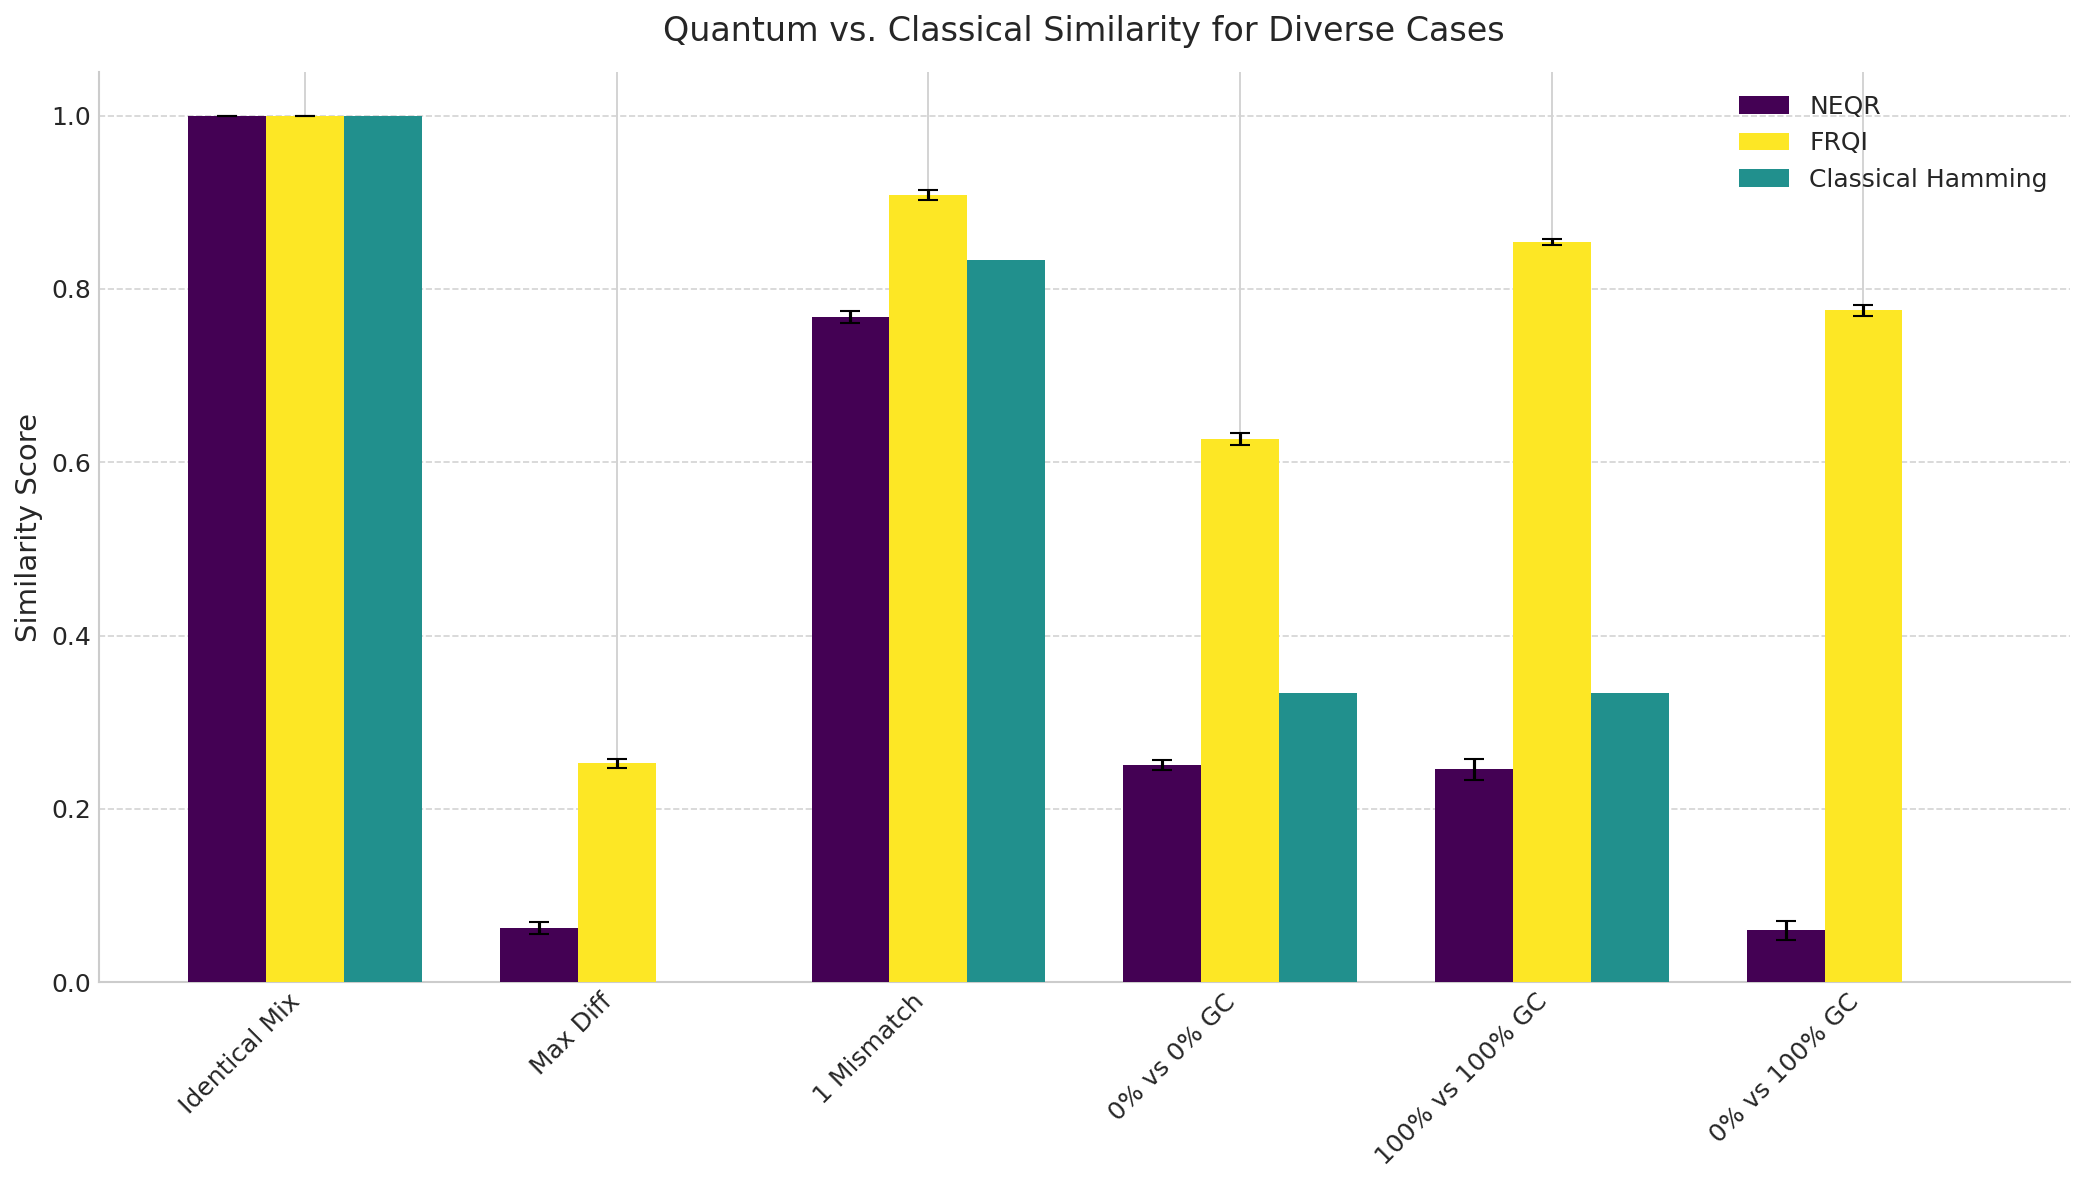

 Diversity analysis complete.

 Running Statistical Analysis across GC content...


Testing GC content levels:   0%|          | 0/3 [00:00<?, ?it/s]

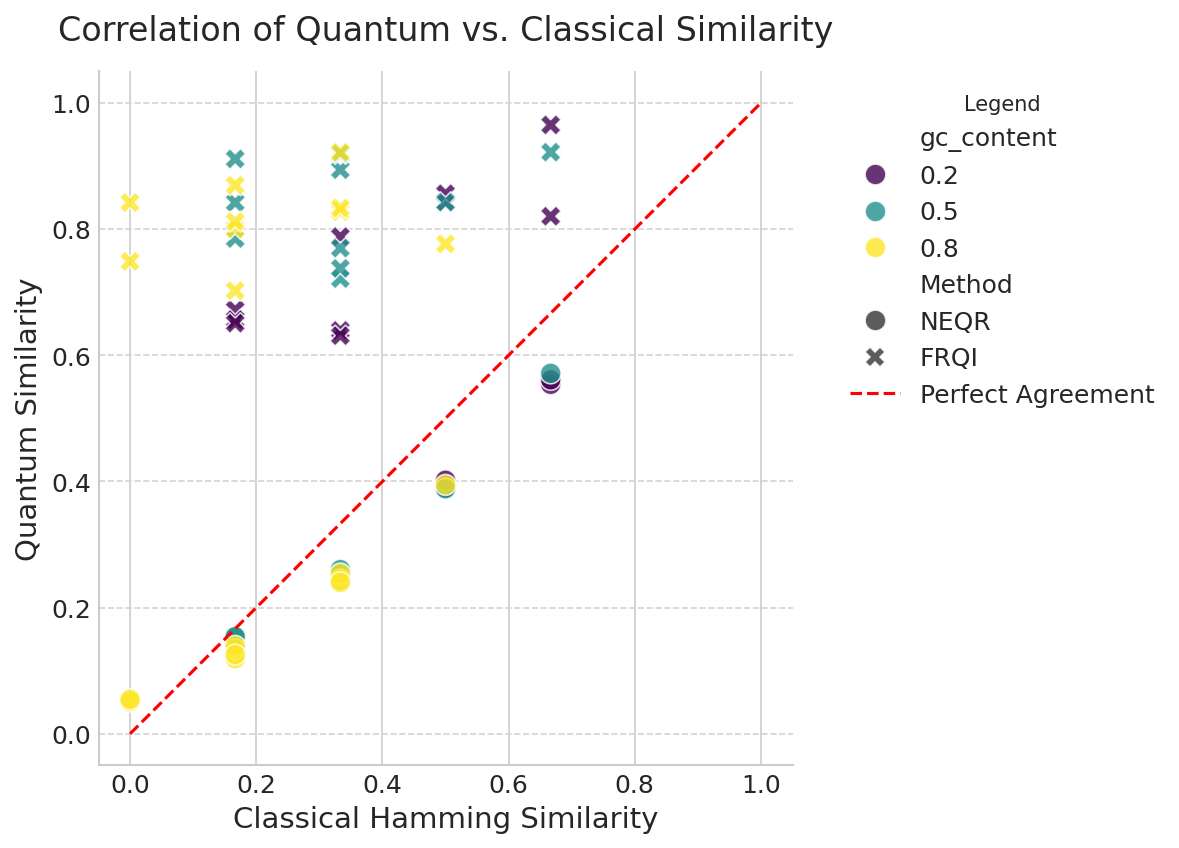

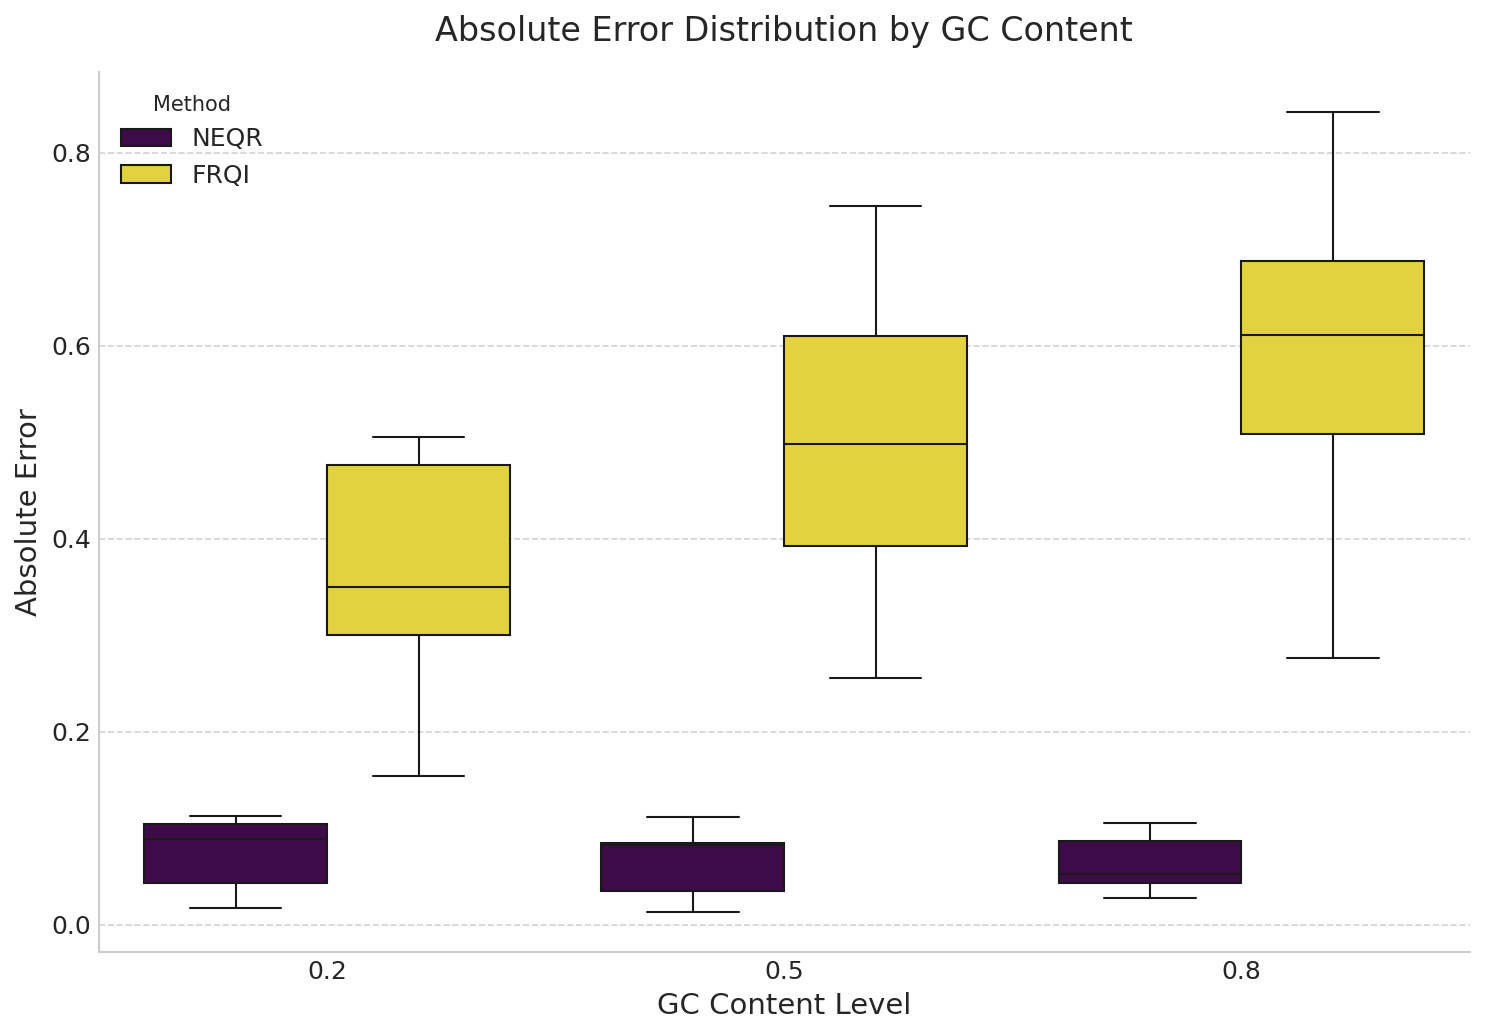


🔊 Running Noise Analysis across GC content...


Noise Analysis:   0%|          | 0/45 [00:00<?, ?it/s]

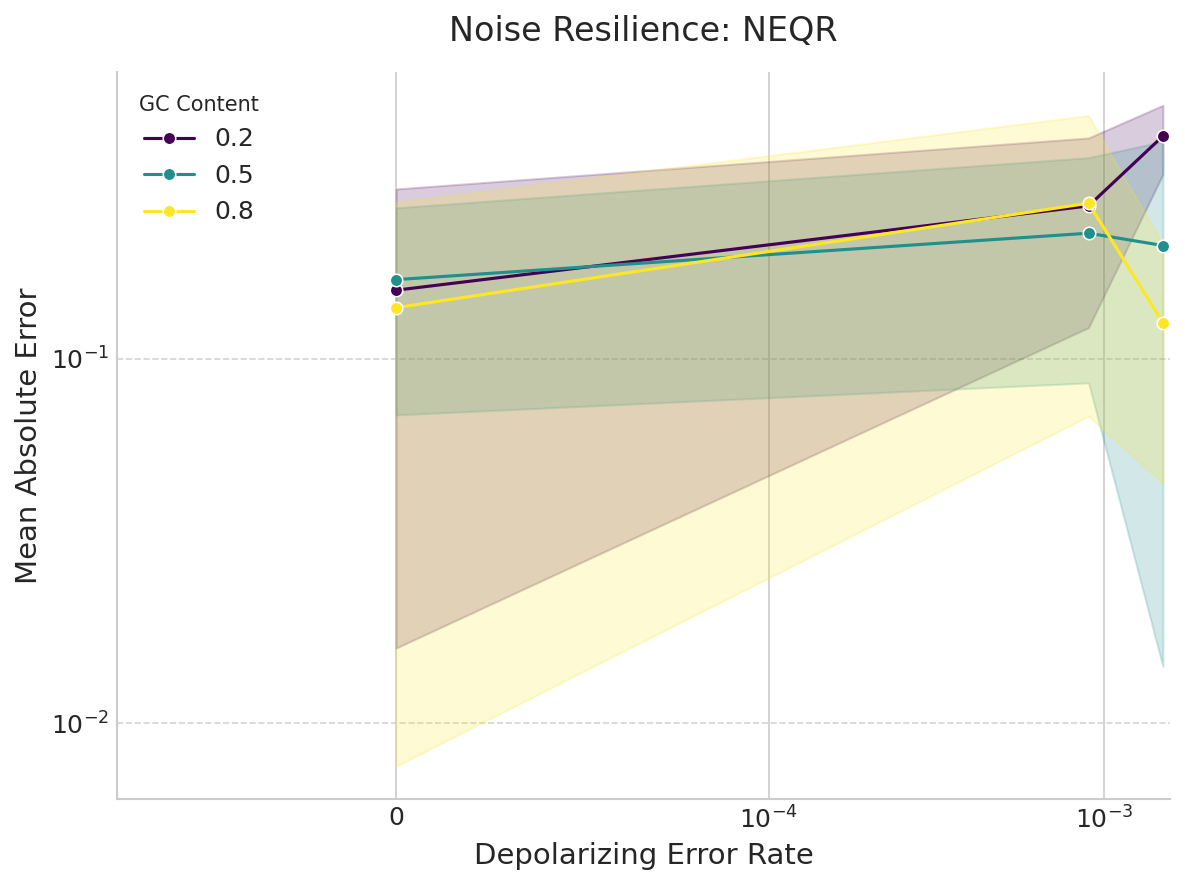

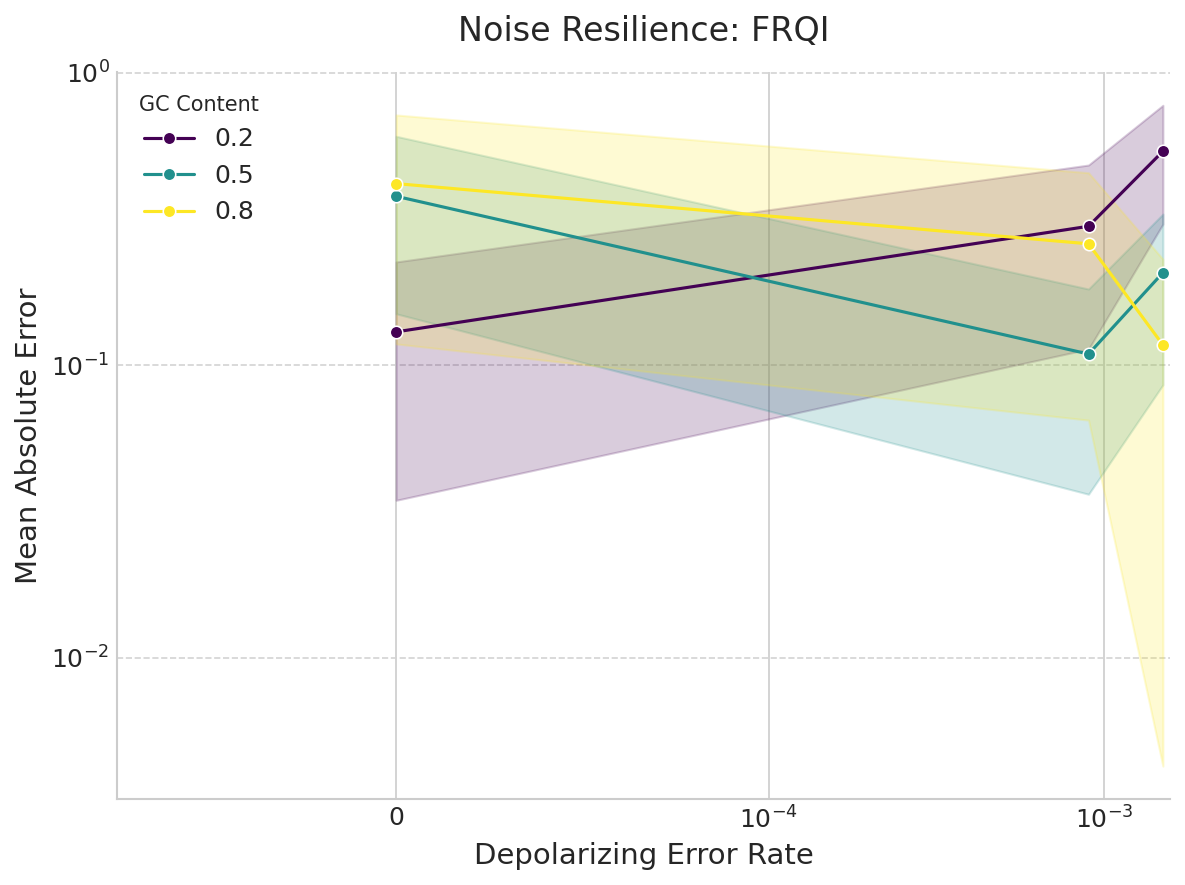

 Noise analysis complete.

 Generating Comprehensive Report...


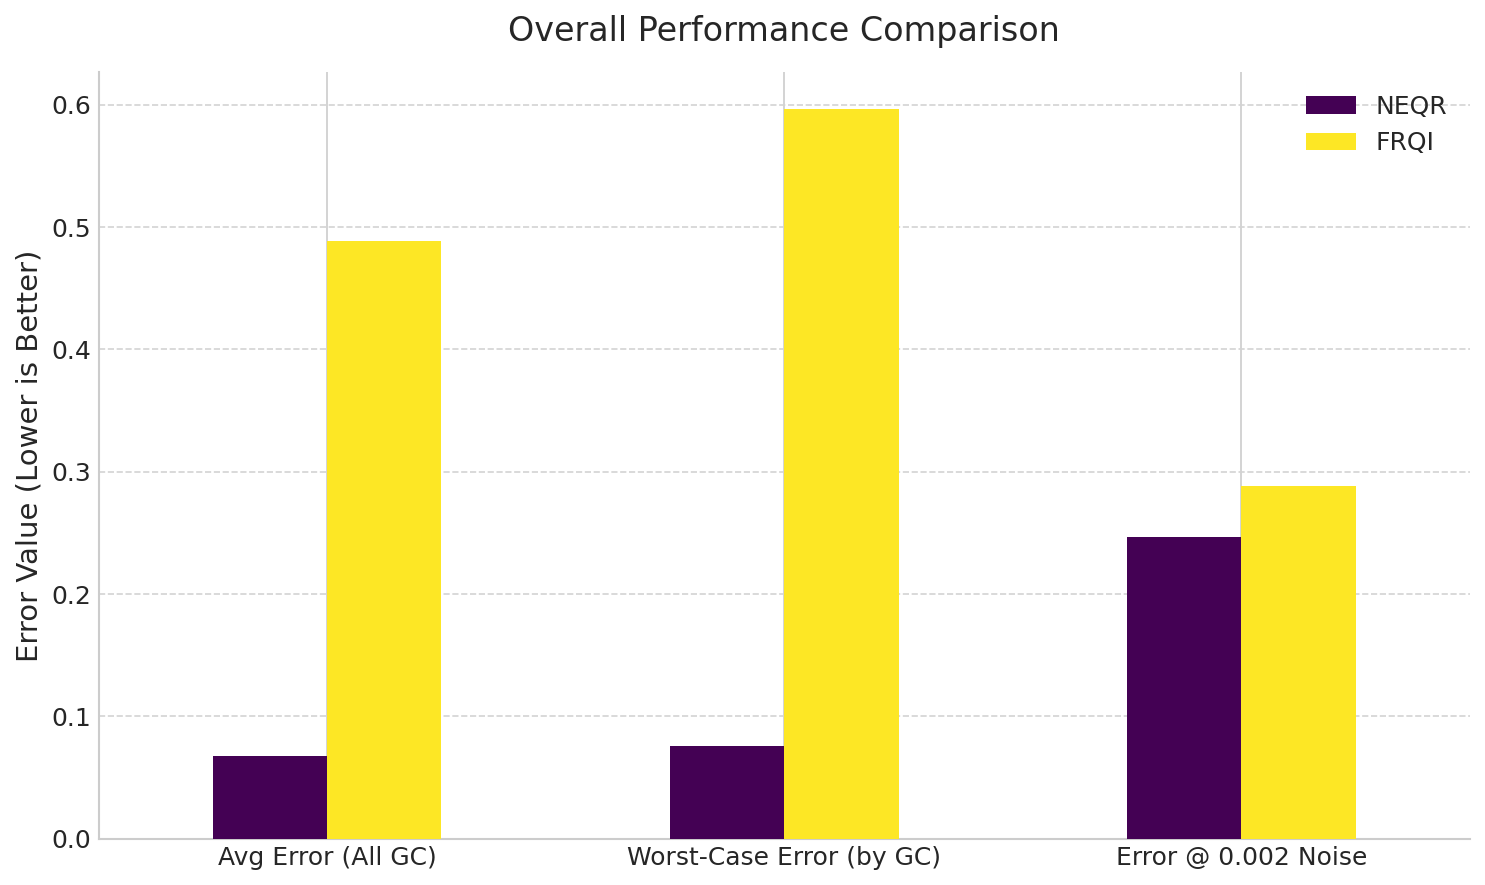

 Comprehensive report generated!

 Summary of Results:
                            NEQR    FRQI  NEQR_is_Better
Avg Error (All GC)        0.0679  0.4889            True
Worst-Case Error (by GC)  0.0756  0.5967            True
Error @ 0.002 Noise       0.2464  0.2882            True

 ENHANCED ANALYSIS COMPLETE!
Completed at: 2025-08-14 20:25:10


In [ ]:
if __name__ == "__main__":
    main()